## CESM2 - LARGE ENSEMBLE (LENS2)

#### by Mauricio Rocha and Dr. Gustavo Marques

#### The objective of this notebook is to cut out the South Atlantic region, but keeping a part of the Tropical Atlantic so that the Intertropical Convergence Zone (ITCZ) region is contemplated.
#### The area we selected is 60°S-20°N and 70°W-20°E.


## Imports

In [1]:
import intake
import intake_esm
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import fsspec
import cmocean
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import pop_tools
import sys
from distributed import Client
from ncar_jobqueue import NCARCluster
sys.path.append('/glade/u/home/mauricio/south_atlantic_heat_balance/functions')
import util
from cartopy.util import add_cyclic_point
from misc import get_ij

/glade/u/apps/opt/conda/envs/npl/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


## Improve the workflow using clusters 

##### We tested different numbers of workers and memory so as to decide which one had better computational performance evaluated by the following: How much time does it require to process the average of 11 members and 10000 days of SST? 
##### code line used to that test: sst_mean = ds.SST.isel(member_id=slice(0, 10)).isel(time=slice(0,10000)).mean(dim=["member_id","time"]).plot()
##### Results:
###### * 40 workers and 20 Gb of memory took 14 sec. 
###### * 70 workers and 5 Gb of memeory took 15.2 sec.
###### * 10 workers and 35 Gb of memory took 35 sec. 
###### * 40 workers and 3 Gb of memory did not work due to the too low memory. 
###### * 40 workers and 6 Gb of memory took 14.4 sec.
###### * 50 workers and 0.5 Gb of memory did not work due to the too low memory.
###### * 50 workers and 1 Gb of memory took did not work due to the too low memory.
###### * 60 workers and 6 Gb of memory took 13.7 sec and was the WINNER!

In [2]:
cluster = NCARCluster(cores=2, # The number of cores you want
                      processes=1, # How many processes
                      resource_spec='select=1:ncpus=1:mem=6GB') # Specify resources
cluster.scale(60) # Workers
client = Client(cluster)
client

/glade/u/apps/opt/conda/envs/npl/lib/python3.7/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43871 instead
  f"Port {expected} is already in use.\n"


Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mauricio/mrocha/proxy/43871/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mauricio/mrocha/proxy/43871/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.63:40138,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mauricio/mrocha/proxy/43871/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Data Ingest

#### Path

In [3]:
%%time
catalog = intake.open_esm_datastore(
    '/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cesm2-le.json'
)

/glade/u/home/mauricio/.local/lib/python3.7/site-packages/intake_esm/core.py:84: DtypeWarning: Columns (5,6,9) have mixed types.Specify dtype option on import or set low_memory=False.
  self._df, self.catalog_file = _fetch_catalog(self.esmcol_data, esmcol_obj, csv_kwargs)


CPU times: user 28.1 s, sys: 1.78 s, total: 29.9 s
Wall time: 31.6 s


In [ ]:
catalog.df

#### How does the variable look like? 

In [4]:
cat_subset = catalog.search(component='ocn',
                            variable='SST',
                            frequency='day_1')
#                           frequency='day_1').df.variable.unique() # Here, you can see all the variables available for the frequency and for the component specified. 

In [5]:
%%time
dset_dict_raw = cat_subset.to_dataset_dict()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream.forcing_variant.variable'


CPU times: user 1min 43s, sys: 2.69 s, total: 1min 46s
Wall time: 2min 3s


In [6]:
ds = dset_dict_raw['ocn.historical.pop.h.nday1.cmip6.SST']   # daily

In [7]:
ds

<xarray.Dataset>
Dimensions:                 (z_t: 60, z_t_150m: 15, z_w: 60, z_w_top: 60, z_w_bot: 60, nlat: 384, nlon: 320, time: 60225, d2: 2, member_id: 50)
Coordinates:
  * z_t                     (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m                (z_t_150m) float32 500.0 1.5e+03 ... 1.45e+04
  * z_w                     (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_top                 (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_bot                 (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
    ULONG                   (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG                   (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time                    (time) object 1850-01-02 00:00:00 ... 2015-01-01 ...
  * member_id               (member_id) <U12 'r10i1181p1f1' ... 'r9i1301p1f1'
Dimensions without coordinates: nlat, nlon, d2
Data variables: (12/52)
    dz                      (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    dzw                     (z_w) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    KMT                     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    KMU                     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    REGION_MASK             (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    UAREA                   (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ...                      ...
    salinity_factor         float64 ...
    sflux_factor            float64 ...
    nsurface_t              float64 ...
    nsurface_u              float64 ...
    time_bound              (time, d2) object dask.array<chunksize=(3650, 2), meta=np.ndarray>
    SST                     (member_id, time, nlat, nlon) float32 dask.array<chunksize=(1, 3650, 384, 320), meta=np.ndarray>
Attributes:
    intake_esm_varname:      ['SST']
    source:                  CCSM POP2, the CCSM Ocean Component
    Conventions:             CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf...
    time_period_freq:        day_1
    calendar:                All years have exactly  365 days.
    history:                 none
    model_doi_url:           https://doi.org/10.5065/D67H1H0V
    cell_methods:            cell_methods = time: mean ==> the variable value...
    revision:                $Id$
    contents:                Diagnostic and Prognostic Variables
    intake_esm_dataset_key:  ocn.historical.pop.h.nday1.cmip6.SST

##### Here we know that the structure used 850 chunks and each chunk has 1.67 GB. The total data memory is 1.35 TB. Each member has 27 GB.

## Test

#### Here we made a test to evaluate the amount of workers and memory. We plotted the average SST from the first to the eleventh member and from the first to 10000 time. 

CPU times: user 471 ms, sys: 55.1 ms, total: 526 ms
Wall time: 14.1 s


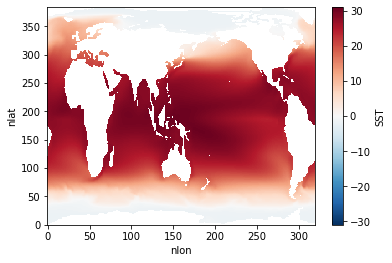

In [8]:
%%time
#SST_mean=ds.SST.isel(time=slice(0,10000)).mean(dim="time")[1,:,:].compute()
#SST_mean.plot()
sst_mean = ds.SST.isel(member_id=slice(0, 10)).isel(time=slice(0,10000)).mean(dim=["member_id","time"]).plot()

In [11]:
sst_mean = ds.SST.isel(member_id=slice(0, 10)).isel(time=slice(0,10000)).mean(dim=['member_id','time'])
sst_mean

<xarray.DataArray 'SST' (nlat: 384, nlon: 320)>
dask.array<mean_agg-aggregate, shape=(384, 320), dtype=float32, chunksize=(384, 320), chunktype=numpy.ndarray>
Coordinates:
    ULONG    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG    (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 318.9 319.4 319.8
    TLAT     (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
Dimensions without coordinates: nlat, nlon

#### Import the POP grid

##### If you choose the ocean component of LENS2, you will need to import the POP grid. For the other components, you can use the emsemble's own grid. 

##### In ds, TLONG and TLAT have missing values (NaNs), so we need to override them with the values from pop_grid, which does not have missing values

In [12]:
# Read the pop 1 deg grid from pop_tools
# We will use variables TLONG and TLAT
pop_grid = pop_tools.get_grid('POP_gx1v7')
ds['TLONG'] = pop_grid.TLONG   # Longitud
ds['TLAT'] = pop_grid.TLAT     # Latitudes

## Map 

CPU times: user 4.53 s, sys: 37.5 ms, total: 4.57 s
Wall time: 16 s


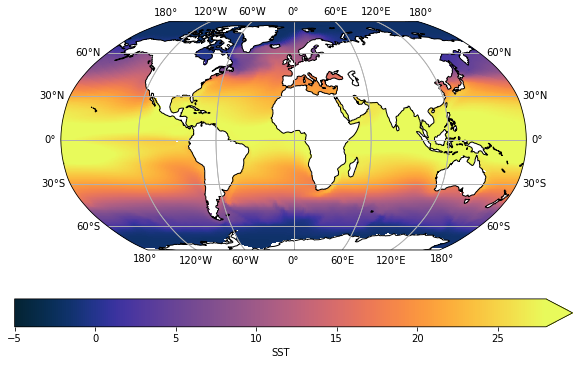

In [19]:
%%time
plt.figure(figsize=(10,6));
ax = plt.axes(projection=ccrs.Robinson());
pc = sst_mean.plot.pcolormesh(ax=ax,
#pc = ds.SST.isel(time=0, member_id=0).plot.pcolormesh(ax=ax,
                                    transform=ccrs.PlateCarree(),
                                    cmap=cmocean.cm.thermal,
                                    x='TLONG',
                                    y='TLAT',
                                    vmin=-5,
                                    vmax=28,
                                    cbar_kwargs={"orientation": "horizontal"})                                    
ax.gridlines(draw_labels=True);
ax.coastlines()
ax.gridlines()

In [17]:
#dsp = util.pop_add_cyclic(ds)
#dsp

#### Centralize the South Atlantic 

In [20]:
pop_grid

<xarray.Dataset>
Dimensions:      (nlat: 384, nlon: 320, z_t: 60, z_w: 60, z_w_bot: 60, nreg: 13)
Coordinates:
  * z_t          (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * z_w          (z_w) float64 0.0 1e+03 2e+03 3e+03 ... 4.75e+05 5e+05 5.25e+05
  * z_w_bot      (z_w_bot) float64 1e+03 2e+03 3e+03 ... 5e+05 5.25e+05 5.5e+05
  * nreg         (nreg) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nlat, nlon
Data variables: (12/15)
    TLAT         (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    TLONG        (nlat, nlon) float64 320.6 321.7 322.8 ... 318.9 319.4 319.8
    ULAT         (nlat, nlon) float64 -78.95 -78.95 -78.95 ... 72.42 72.41 72.41
    ULONG        (nlat, nlon) float64 321.1 322.3 323.4 ... 319.2 319.6 320.0
    DXT          (nlat, nlon) float64 1.894e+06 1.893e+06 ... 1.473e+06
    DYT          (nlat, nlon) float64 5.94e+06 5.94e+06 ... 5.046e+06 5.046e+06
    ...           ...
    UAREA        (nlat, nlon) float64 1.423e+13 1.423e+13 ... 7.639e+12
    KMT          (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    REGION_MASK  (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    dz           (z_t) float64 1e+03 1e+03 1e+03 ... 2.499e+04 2.5e+04 2.5e+04
    region_name  (nreg) <U21 'Black Sea' 'Baltic Sea' ... 'Hudson Bay'
    region_val   (nreg) int64 -13 -12 -5 1 2 3 4 6 7 8 9 10 11
Attributes:
    lateral_dims:       [384, 320]
    vertical_dims:      60
    vert_grid_file:     gx1v7_vert_grid
    horiz_grid_fname:   inputdata/ocn/pop/gx1v7/grid/horiz_grid_20010402.ieeer8
    topography_fname:   inputdata/ocn/pop/gx1v7/grid/topography_20161215.ieeei4
    region_mask_fname:  inputdata/ocn/pop/gx1v7/grid/region_mask_20151008.ieeei4
    type:               dipole
    title:              POP_gx1v7 grid

In [21]:
%time
#i, j = get_ij(90, -22, pop_grid) 90 is lon (_i), -22 is lat (_j)
sw_i, sw_j = get_ij(-70, -60, pop_grid) # southwest
se_i, se_j = get_ij(20, -60, pop_grid) # southeast
nw_i, nw_j = get_ij(0, 20, pop_grid) # northwest
ne_i, ne_j = get_ij(320, 20, pop_grid) # northeast

print('Southwest Edge: sw_i = {}, sw_j = {}'.format(sw_i,sw_j))
print('Southeast Edge: se_i = {}, se_j = {}'.format(se_i,se_j))
print('Northwest Edge: nw_i = {}, nw_j = {}'.format(nw_i,nw_j))
print('Northeast Edge: ne_i = {}, ne_j = {}'.format(ne_i,ne_j))

# number of grid points to expand over all directions
#n = 50
#print('Region is defined by i = {},{}, j = {},{}'.format(i-n,i+n,j-n,j+n))

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs
Southwest Edge: sw_i = 36, sw_j = 36
Southeast Edge: se_i = 53, se_j = 36
Northwest Edge: nw_i = 36, nw_j = 256
Northeast Edge: ne_i = 319, ne_j = 257


#### Extract area and define start and end dates

In [22]:
%time
area = pop_grid.TAREA.isel(nlon = slice(nw_i,ne_i), 
                           nlat = slice(sw_j,ne_j))
start = "1960-01-01" # first time
end   = "2015-01-01" # last time
area

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.53 µs


<xarray.DataArray 'TAREA' (nlat: 221, nlon: 283)>
array([[3.71581040e+13, 3.71581040e+13, 3.71581040e+13, ...,
        3.71581040e+13, 3.71581040e+13, 3.71581040e+13],
       [3.77562808e+13, 3.77562808e+13, 3.77562808e+13, ...,
        3.77562808e+13, 3.77562808e+13, 3.77562808e+13],
       [3.83511749e+13, 3.83511749e+13, 3.83511749e+13, ...,
        3.83511749e+13, 3.83511749e+13, 3.83511749e+13],
       ...,
       [5.11565294e+13, 5.12158006e+13, 5.12763590e+13, ...,
        5.00473256e+13, 5.00420545e+13, 5.00385392e+13],
       [5.20097580e+13, 5.20714819e+13, 5.21345455e+13, ...,
        5.08545119e+13, 5.08490214e+13, 5.08453598e+13],
       [5.28556281e+13, 5.29198801e+13, 5.29855258e+13, ...,
        5.16529061e+13, 5.16471891e+13, 5.16433766e+13]])
Dimensions without coordinates: nlat, nlon
Attributes:
    units:        cm^2
    long_name:    area of T cells
    coordinates:  TLONG TLAT

In [23]:
%%time
ds_remapped = ds.SST.isel(nlon = slice(nw_i,ne_i), nlat = slice(sw_j,ne_j),
                            ).sel(time = slice(start,end)).weighted(area).mean(dim=['time']).load()

KilledWorker: ("('broadcast_to-concatenate-open_dataset-getitem-dc58b5c77dcfb96dd7ab4a380fe363d2', 39, 3, 0, 0)", <WorkerState 'tcp://10.12.206.32:33657', name: PBSCluster-32, status: closed, memory: 0, processing: 3>)

In [24]:
ds_remapped

NameError: name 'ds_remapped' is not defined

In [ ]:
#ds_remapped.isel(member_id = 10).plot()

In [ ]:
%time
plt.figure(figsize=(10,6));
ax = plt.axes(projection=ccrs.Robinson());
pc = ds_remapped.isel(member_id=0).plot.pcolormesh(ax=ax,
                                    transform=ccrs.PlateCarree(),
                                    cmap=cmocean.cm.thermal,
                                    x='TLONG',
                                    y='TLAT',
                                    vmin=-2,
                                    vmax=32,
                                    cbar_kwargs={"orientation": "horizontal"})                                    
ax.gridlines(draw_labels=True);
ax.coastlines()
ax.gridlines()